In [1]:
#imports
import pandas as pd
import json
import requests
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress

In [2]:
#import biggest cities data
cities_file = 'biggest_cities_per_state.json'
with open(cities_file ,'r') as file:
    city_data = json.loads(file.read())
    
#make into dataframe
cities_info = pd.json_normalize(city_data).T
cities_info.head()

,0
AK,"[[Anchorage, -149.90028, 61.21806], 298695.0]"
AL,"[[Birmingham, -86.80249, 33.52066], 212461.0]"
AR,"[[Little Rock, -92.28959, 34.74648], 197992.0]"
AZ,"[[Phoenix, -112.07404, 33.44838], 1563025.0]"
CA,"[[Los Angeles, -118.24368, 34.05223], 3971883.0]"


In [3]:
#clean df
cities_list = []
lng_list = []
lat_list = []
population_list = []

for i in range(51):
    population_list.append(cities_info[0][i][1])
    cities_list.append(cities_info[0][i][0][0])
    lng_list.append(cities_info[0][i][0][1])
    lat_list.append(cities_info[0][i][0][2])
    
cities_info["City"] = cities_list
cities_info["Latitude"] = lat_list 
cities_info["Longitude"] = lng_list
cities_info["Population"] = population_list
cities_info_clean = cities_info[["City","Latitude","Longitude","Population"]]
cities_info_clean = cities_info_clean.reset_index(drop=False)
cities_info_clean = cities_info_clean.rename(columns={"index":"State"})
cities_info_clean.head()


,State,City,Latitude,Longitude,Population
0,AK,Anchorage,61.21806,-149.90028,298695.0
1,AL,Birmingham,33.52066,-86.80249,212461.0
2,AR,Little Rock,34.74648,-92.28959,197992.0
3,AZ,Phoenix,33.44838,-112.07404,1563025.0
4,CA,Los Angeles,34.05223,-118.24368,3971883.0


In [67]:
#add data from teleport manually since its not accessable through the api
leisure_culture_score = [3,5,0,7,9,6,0,10,0,6,8,8,6,4,8,7,0,0,7,9,0,3,7,7,7,0,0,6,0,5,0,0,5,6,10,6,5,6,8,4,0,0,7,7,6,0,0,8,7,0,0]
cities_info_clean["Leisure/Culture Score"] = leisure_culture_score
arts_venues = [159,429,0,839,1244,1024,0,926,0,661,1430,495,407,292,1409,878,0,0,541,1279,0,224,1146,968,860,0,0,590,0,685,0,0,398,834,1573,498,630,528,1613,265,0,0,413,955,498,0,0,1059,774,0,0]
#arts venues = art galleries + cinemas + comedy clubs + concert venues + performing arts venues
cities_info_clean["Arts Venues"] = arts_venues
educational_entertainment_venues = [32,95,0,219,621,240,0,579,0,159,456,182,100,63,516,251,0,0,165,498,0,53,417,295,254,0,0,112,0,143,0,0,67,185,636,232,169,177,548,83,0,0,166,392,116,0,0,356,271,0,0]
#ed entertainment = historical sites + museums + zoos
cities_info_clean['Educational Entertainment Venues'] = educational_entertainment_venues
sport_venues = [9,45,0,58,222,133,0,221,0,85,202,25,43,30,214,133,0,0,73,179,0,6,190,165,131,0,0,32,0,64,0,0,10,41,175,82,109,77,212,17,0,0,52,173,15,0,0,132,116,0,0]
cities_info_clean["Sports Venues"] = sport_venues
cities_info_clean['Total Venues'] = cities_info_clean[["Arts Venues",'Educational Entertainment Venues',"Sports Venues"]].sum(axis=1)
lgbt_index = [76.56,67.19,0,70.00,93.19,93.13,0,100.00,0,67.19,70,96.55,93.13,72.81,96.90,72.81,0,0,72.81,96.88,96.88,93.62,63.24,96.88,72.14,0,0,67.58,0,72.81,0,0,93.13,93.13,86.72,66.79,67.67,96.88,80.47,93.13,0,0,70.00,64.44,92.97,0,0,91.25,82.97,0,0]
cities_info_clean['LGBT Equality Index'] = lgbt_index
minorities_tolerance = [.64,.3,0,.4,.44,.62,0,.31,.0,.46,.1,.56,.74,.65,.23,.64,.0,0,.29,.7,.15,.69,.1,.46,.27,.0,.0,.68,0,.42,0,0,.45,.5,.46,.51,.52,.64,.35,.54,0,0,.1,.42,.77,.0,0,.68,.12,0,0]
cities_info_clean["Tolerance of Minorities Score"] = minorities_tolerance
tolerance_score = [7,5,0,6,7,8,0,7,0,6,4,8,8,7,6,7,0,0,5,8,6,8,4,7,5,0,0,7,0,6,0,0,7,7,7,6,6,8,6,7,0,0,4,5,9,0,0,8,5,0,0]
cities_info_clean["Tolerance Score"] = tolerance_score
cities_info_clean['Average Score'] = cities_info_clean[["Leisure/Culture Score","Tolerance Score"]].mean(axis=1)
venues_per_capita = cities_info_clean['Total Venues'] / cities_info_clean['Population']
cities_info_clean['Venues per Capita'] = venues_per_capita

#drop cities with 0 data
clean_city_data = cities_info_clean
clean_city_data = clean_city_data[clean_city_data['Leisure/Culture Score'] != 0]
clean_city_data = clean_city_data.reset_index(drop=True)
clean_city_data

,State,City,Latitude,Longitude,Population,Leisure/Culture Score,Arts Venues,Educational Entertainment Venues,Sports Venues,Total Venues,LGBT Equality Index,Tolerance of Minorities Score,Tolerance Score,Average Score,Venues per Capita
0,AK,Anchorage,61.21806,-149.90028,298695.0,3,159,32,9,200,76.56,0.64,7,5.0,0.000670
1,AL,Birmingham,33.52066,-86.80249,212461.0,5,429,95,45,569,67.19,0.30,5,5.0,0.002678
2,AZ,Phoenix,33.44838,-112.07404,1563025.0,7,839,219,58,1116,70.00,0.40,6,6.5,0.000714
3,CA,Los Angeles,34.05223,-118.24368,3971883.0,9,1244,621,222,2087,93.19,0.44,7,8.0,0.000525
4,CO,Denver,39.73915,-104.98470,682545.0,6,1024,240,133,1397,93.13,0.62,8,7.0,0.002047
5,DC,Washington,38.89511,-77.03637,601723.0,10,926,579,221,1726,100.00,0.31,7,8.5,0.002868
6,FL,Jacksonville,30.33218,-81.65565,868031.0,6,661,159,85,905,67.19,0.46,6,6.0,0.001043
7,GA,Atlanta,33.74900,-84.38798,463878.0,8,1430,456,202,2088,70.00,0.10,4,6.0,0.004501
8,HI,Honolulu,21.30694,-157.85833,371657.0,8,495,182,25,702,96.55,0.56,8,8.0,0.001889
9,IA,Des Moines,41.60054,-93.60911,210330.0,6,407,100,43,550,93.13,0.74,8,7.0,0.002615


In [5]:
#export cleaned data as csv
clean_city_data.to_csv("culture_data_csv")

In [6]:
#make summary of data
describedata = clean_city_data.describe()
describedata

,Latitude,Longitude,Population,Leisure/Culture Score,Arts Venues,Educational Entertainment Venues,Sports Venues,Total Venues,LGBT Equality Index,Tolerance of Minorities Score,Tolerance Score,Average Score
count,34.000000,34.000000,3.400000e+01,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.00000,34.000000
mean,38.911177,-96.727466,1.016065e+06,6.558824,780.117647,260.235294,102.088235,1142.441176,81.910882,0.463529,6.50000,6.529412
std,6.736287,21.013652,1.495356e+06,1.726639,395.811538,177.433566,71.931519,629.022676,12.520292,0.194950,1.30848,1.029424
min,21.306940,-157.858330,6.688100e+04,3.000000,159.000000,32.000000,6.000000,200.000000,63.240000,0.100000,4.00000,5.000000
25%,35.100750,-110.581073,3.949475e+05,6.000000,495.750000,122.750000,41.500000,648.750000,70.000000,0.320000,6.00000,5.625000
50%,39.860355,-91.669455,6.275465e+05,7.000000,729.500000,202.000000,83.500000,984.000000,81.720000,0.460000,7.00000,6.250000
75%,42.211080,-83.010530,8.290628e+05,7.750000,1010.000000,383.000000,171.000000,1540.250000,93.130000,0.640000,7.00000,7.000000
max,61.218060,-70.258900,8.175133e+06,10.000000,1613.000000,636.000000,222.000000,2384.000000,100.000000,0.770000,9.00000,8.500000


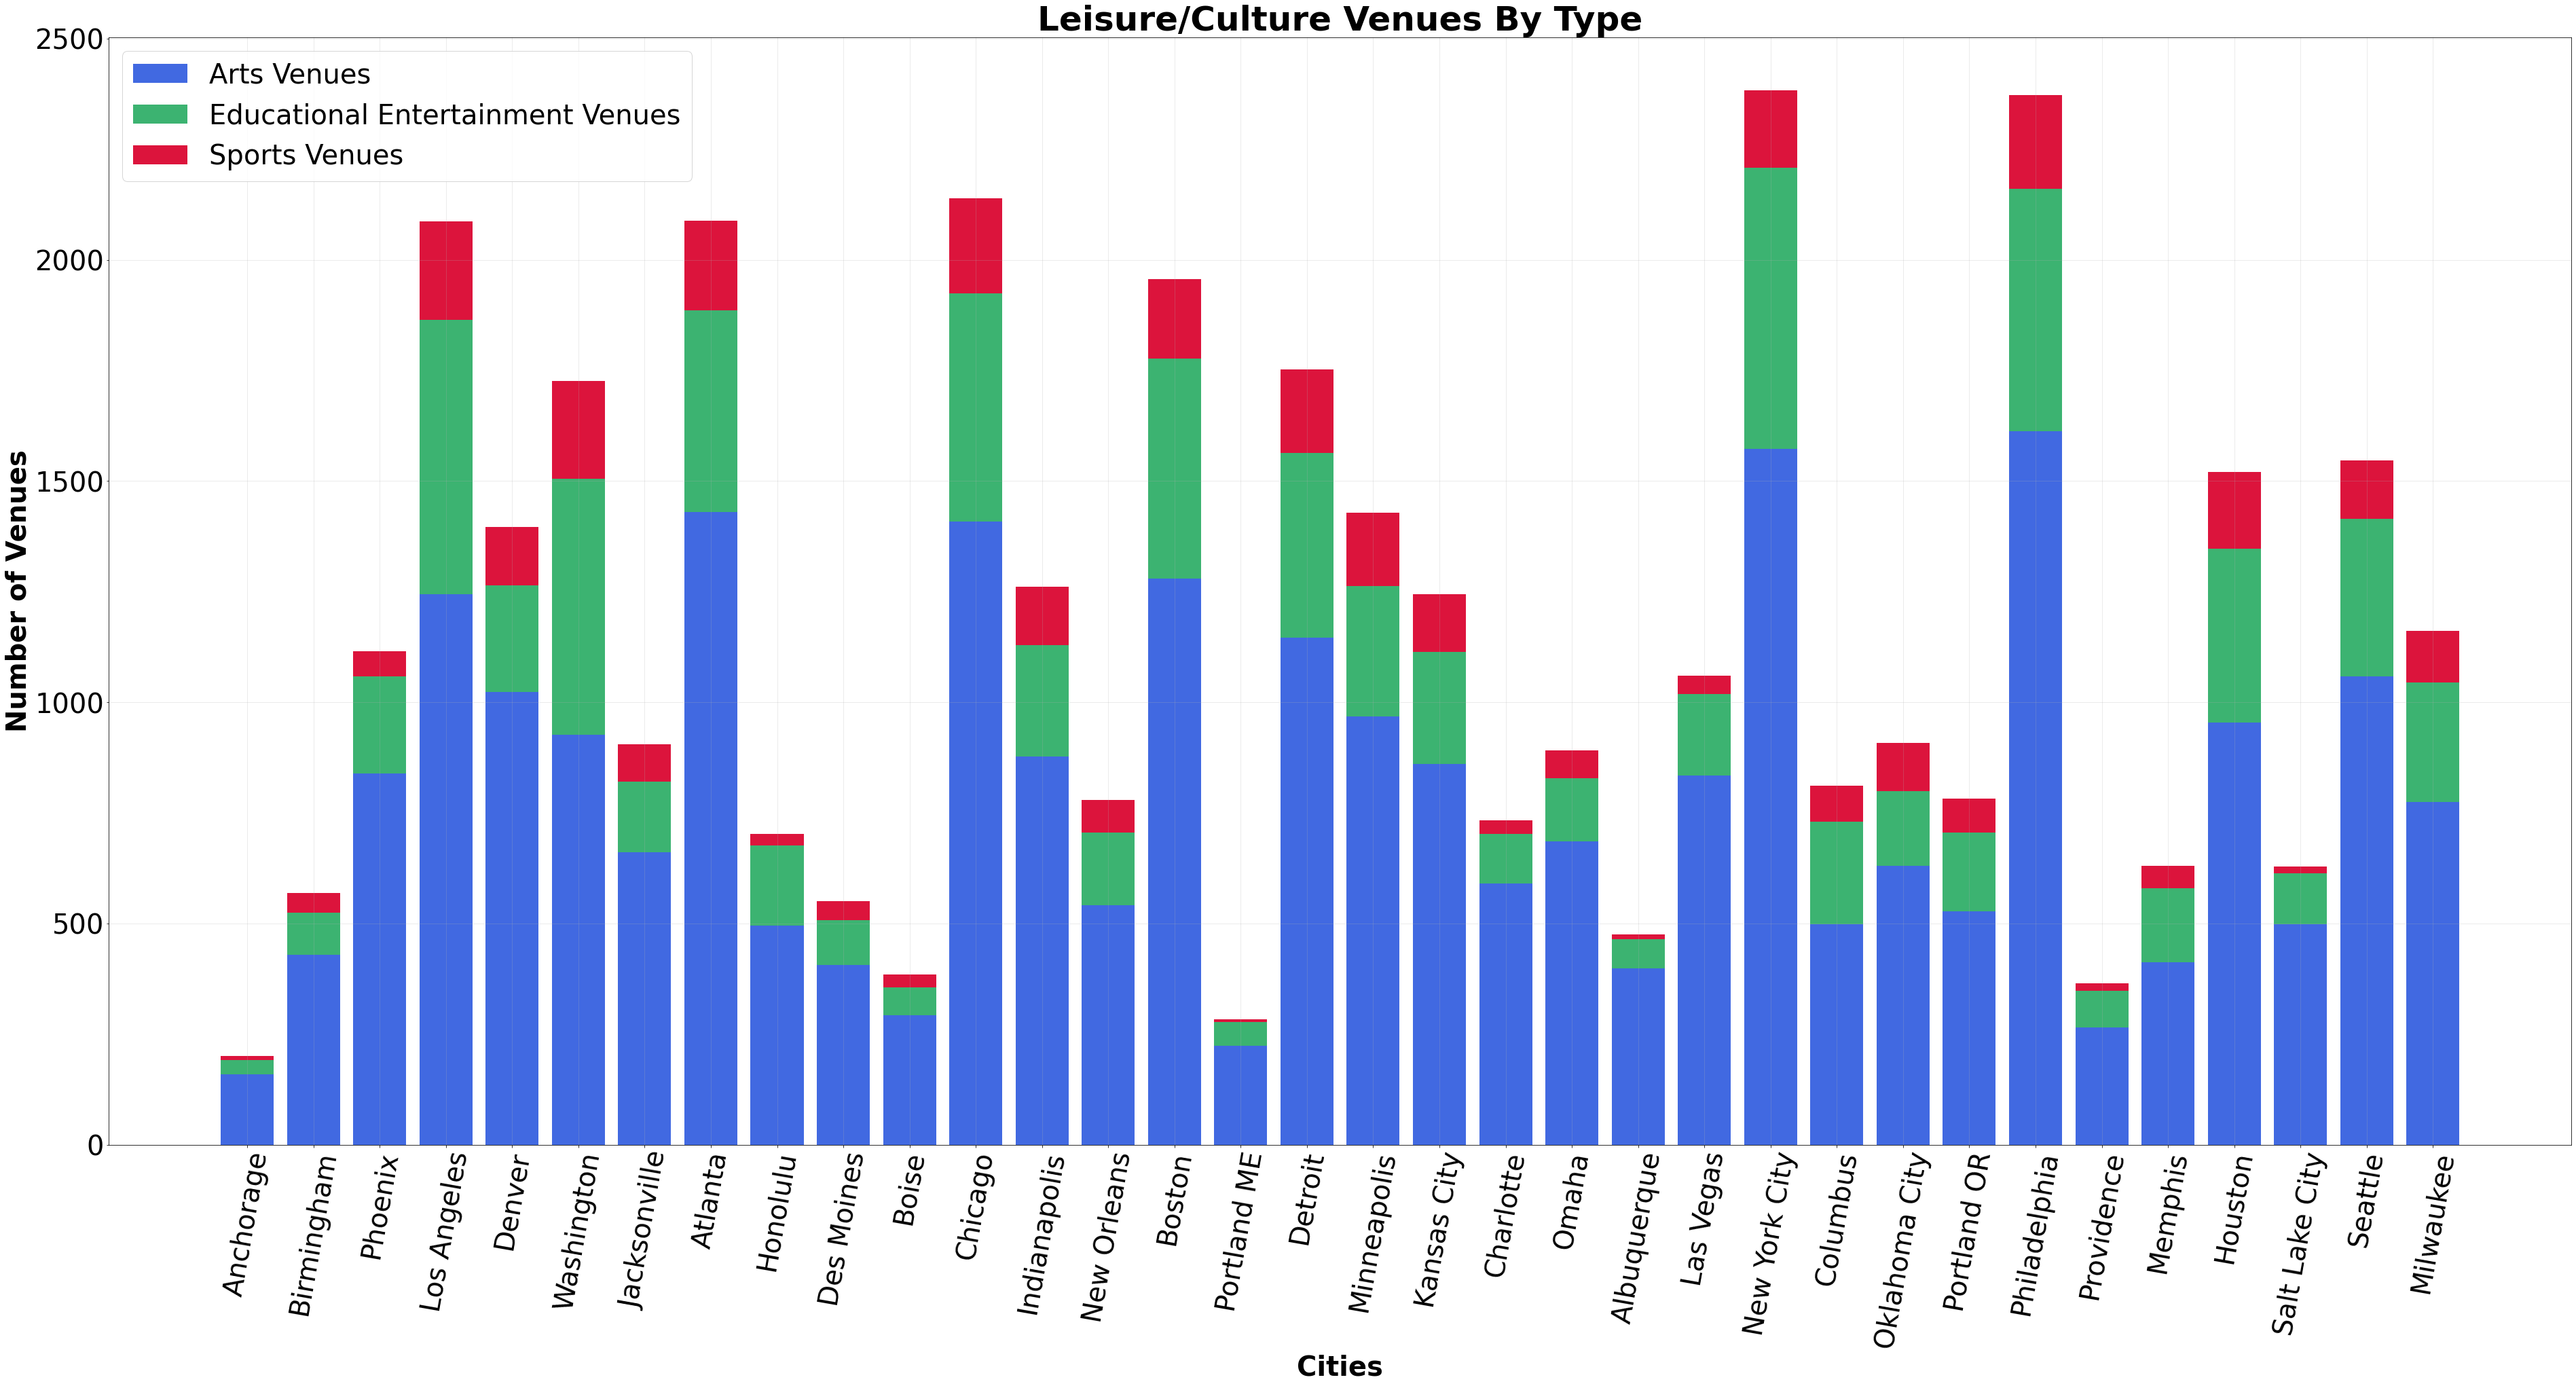

In [7]:
#make stacked bar chart to compare venue categories
plt.subplots(1, figsize=(65, 30))
plt.bar(clean_city_data['City'], clean_city_data['Arts Venues'], color='royalblue')
plt.bar(clean_city_data['City'], clean_city_data['Educational Entertainment Venues'], bottom=clean_city_data['Arts Venues'], color='mediumseagreen')
plt.bar(clean_city_data['City'], clean_city_data['Sports Venues'], bottom=clean_city_data['Arts Venues']+clean_city_data['Educational Entertainment Venues'], color='crimson')

plt.yticks(fontsize=40)
plt.xticks(fontsize=40,rotation = 80)
plt.title("Leisure/Culture Venues By Type", fontsize=50, weight='bold')
plt.xlabel("Cities", fontsize=40, weight='bold')
plt.ylabel("Number of Venues", fontsize=40, weight='bold')
plt.grid(alpha=.3)

plt.legend(['Arts Venues','Educational Entertainment Venues','Sports Venues'],loc='upper left', fontsize=40)

#save as img
plt.savefig("figs/Leisure_Venues_By_Type")

plt.show()

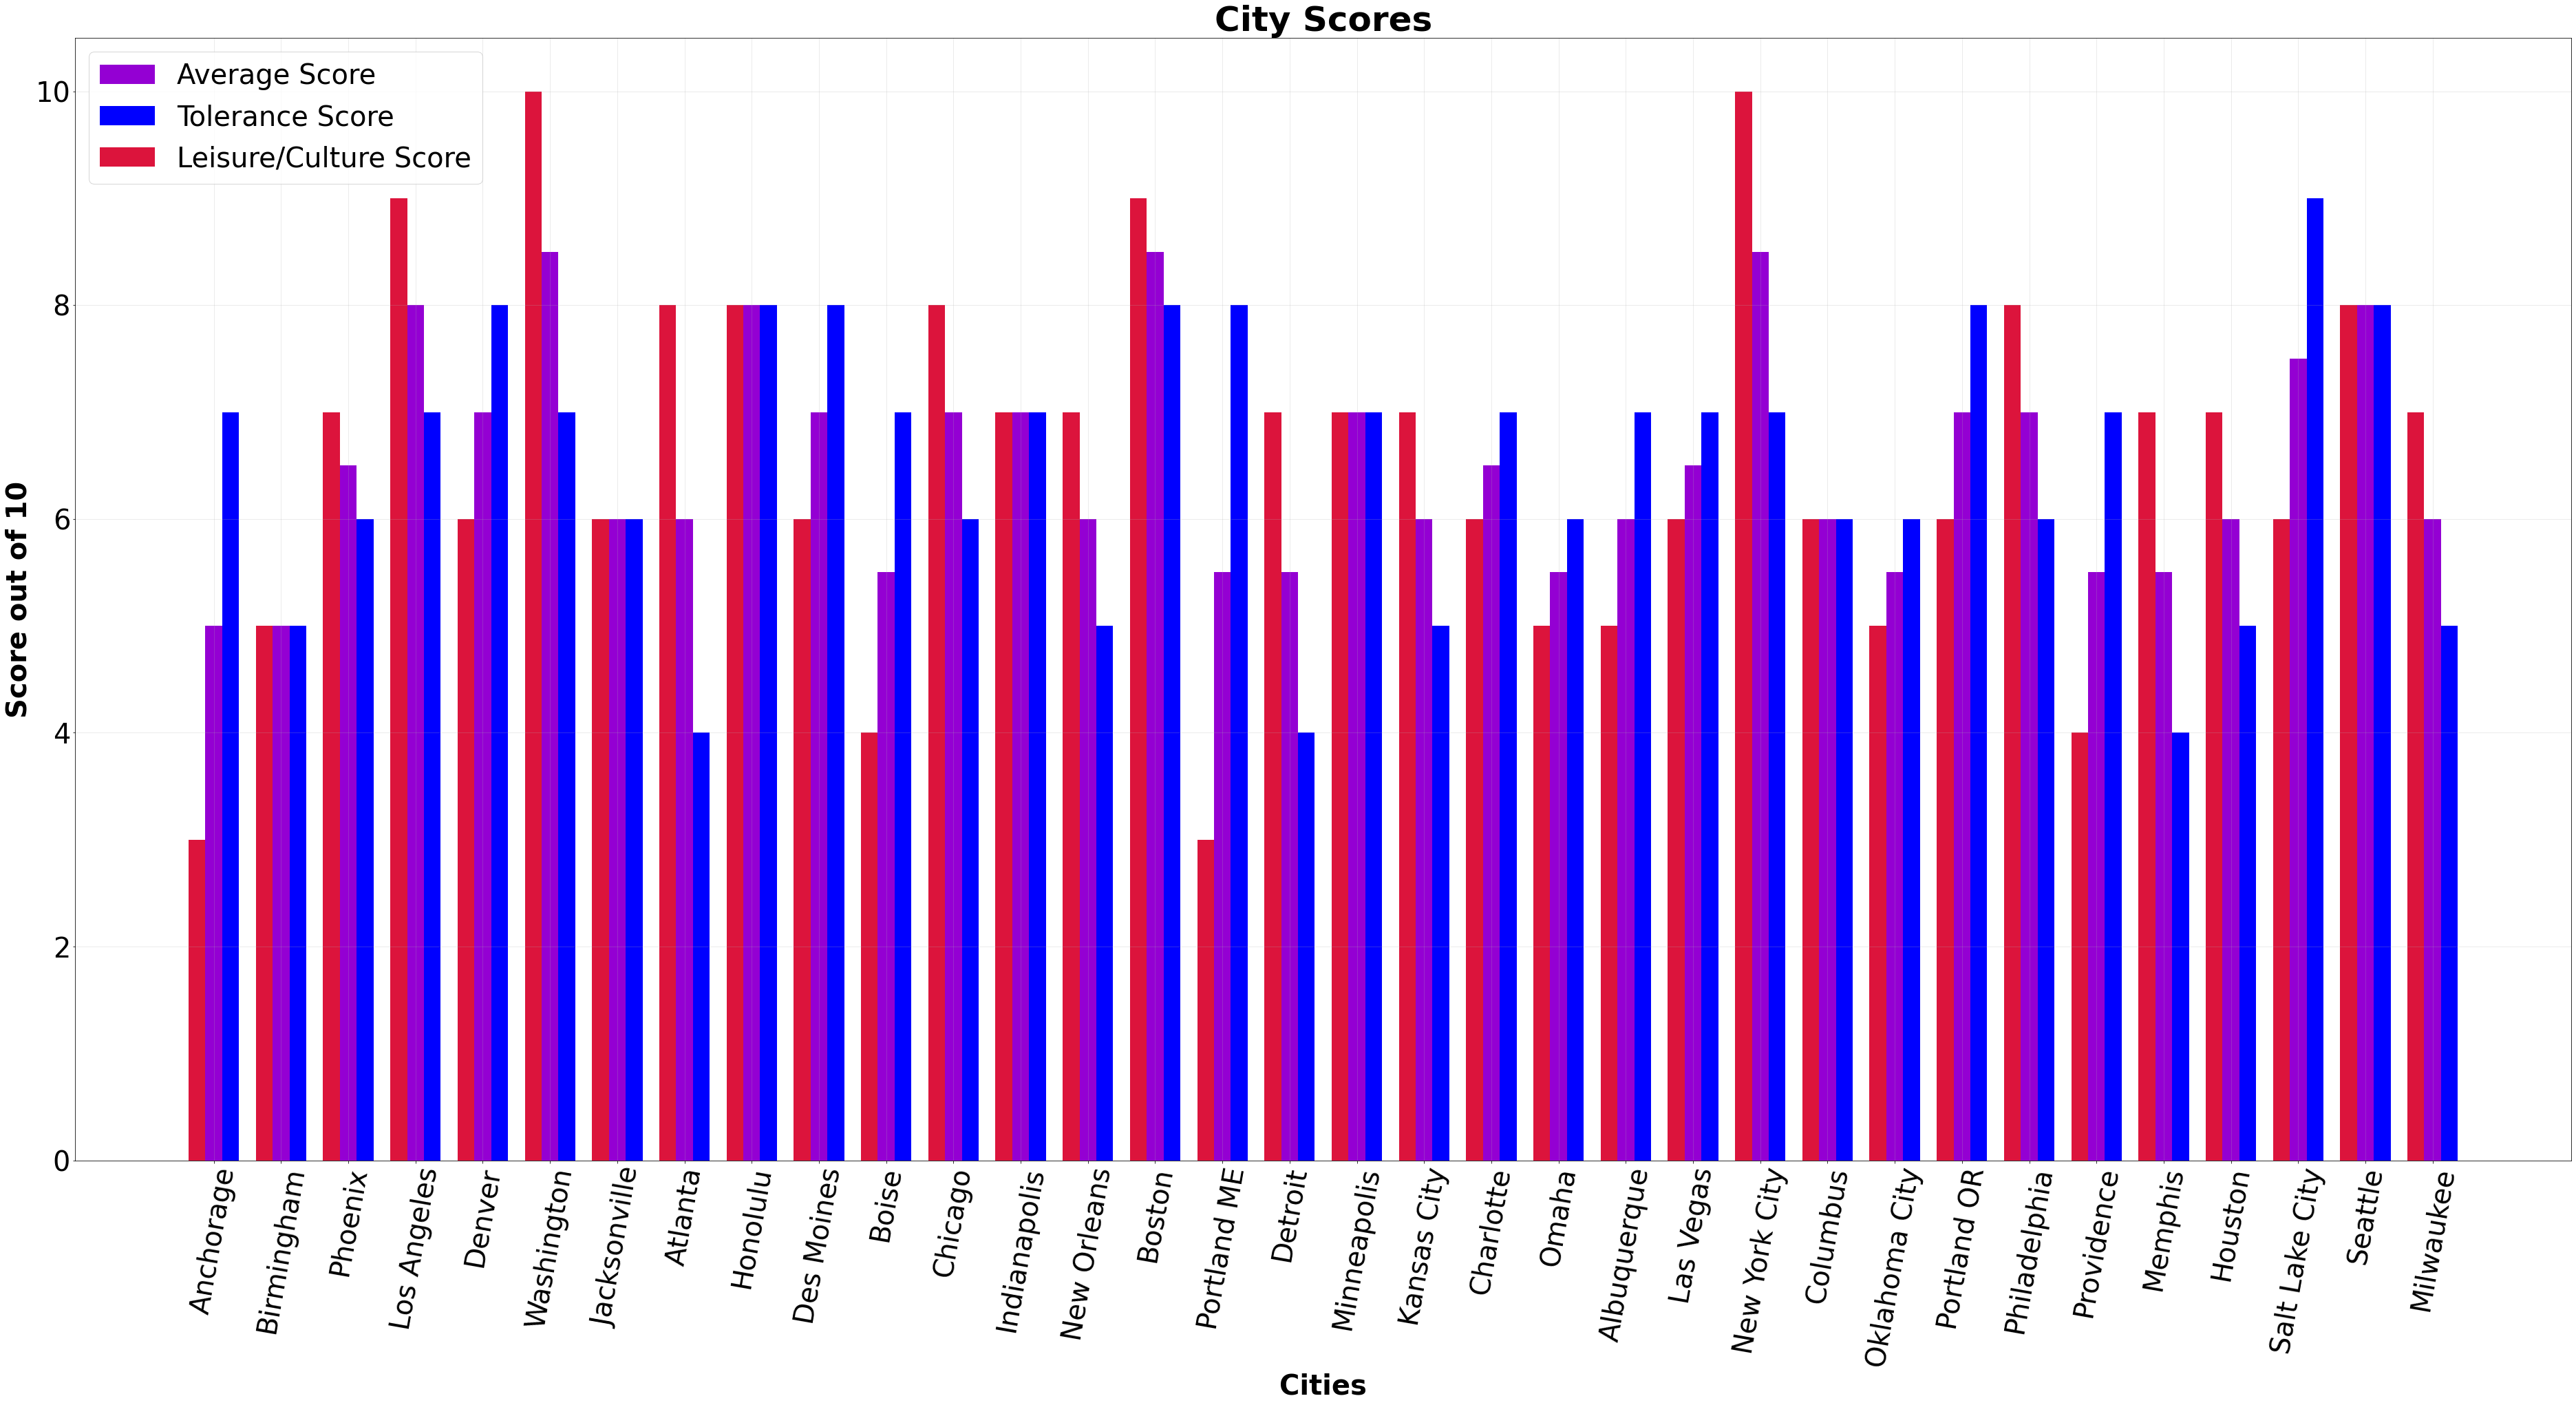

In [95]:
#bar chart comparing tolerance and leisure scores across all cities
plt.subplots(1, figsize=(65, 30))
x = np.arange(0, len(clean_city_data['City']))
plt.bar(x,clean_city_data['Average Score'], color='darkviolet', width=.25)
plt.bar(x + .25,clean_city_data['Tolerance Score'], color='blue', width=.25)
plt.bar(x - .25,clean_city_data['Leisure/Culture Score'], color='crimson', width=.25)

plt.yticks(fontsize=40)
plt.xticks(x,clean_city_data['City'],fontsize=40,rotation = 80)
plt.title("City Scores", fontsize=50, weight='bold')
plt.xlabel("Cities", fontsize=40, weight='bold')
plt.ylabel("Score out of 10", fontsize=40, weight='bold')
plt.grid(alpha=.3)
plt.legend(['Average Score','Tolerance Score','Leisure/Culture Score'],loc='upper left', fontsize=40)

#save as img
plt.savefig("figs/city_scores")

R squared: 0.010119449184491449


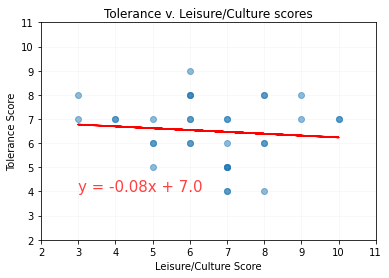

In [8]:
#graph tolerance v. leisure scores
plt.scatter(clean_city_data['Leisure/Culture Score'], clean_city_data['Tolerance Score'], alpha=.5)
plt.ylim(2,11)
plt.xlim(2,11)
plt.xlabel('Leisure/Culture Score')
plt.ylabel('Tolerance Score')
plt.title('Tolerance v. Leisure/Culture scores')
plt.grid(alpha=.1)

#add linear regression line
(slope, intercept, rvalue, pvalue, stderr) = linregress(clean_city_data['Leisure/Culture Score'], clean_city_data['Tolerance Score'])
regress_values = clean_city_data['Leisure/Culture Score'] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(clean_city_data['Leisure/Culture Score'],regress_values,"r-")
plt.annotate(line_eq,(3,4),fontsize=15,color="red", alpha=.75)

print(f"R squared: {rvalue**2}")

#save img
plt.savefig("figs/Tolerance_v_LeisureCulture_scores")

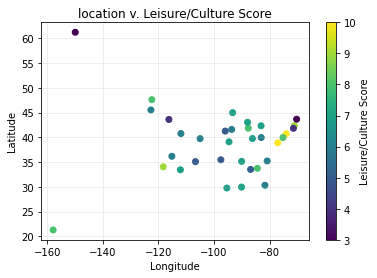

In [9]:
#latitude/longitude scatter with colored points based on culture score
plt.scatter(clean_city_data['Longitude'],clean_city_data['Latitude'],c=clean_city_data['Leisure/Culture Score'])
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Leisure/Culture Score")
plt.title("location v. Leisure/Culture Score")
plt.grid(alpha=.25)

#save as png
plt.savefig("figs/culture_score_v_location")
plt.show()

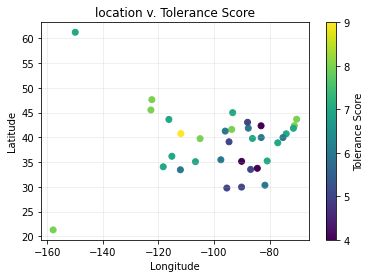

In [10]:
#latitude/longitude scatter with colored points based on tolerance score 
plt.scatter(clean_city_data['Longitude'],clean_city_data['Latitude'],c=clean_city_data['Tolerance Score'])
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Tolerance Score")
plt.title("location v. Tolerance Score")
plt.grid(alpha=.25)

#save as png
plt.savefig("figs/tolerance_v_location")
plt.show()

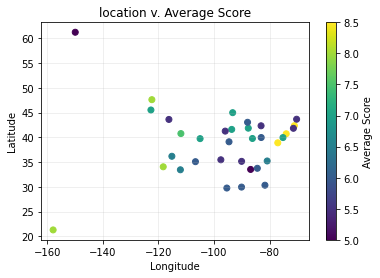

In [11]:
#latitude/longitude scatter with colored points based on average of tolerance and culture score 
plt.scatter(clean_city_data['Longitude'],clean_city_data['Latitude'],c=clean_city_data['Average Score'])
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Average Score")
plt.title("location v. Average Score")
plt.grid(alpha=.25)

#save as png
plt.savefig("figs/location_v_average_score")
plt.show()

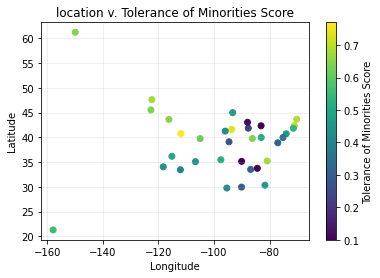

In [12]:
#latitude/longitude scatter with colored points based on tolerance of minorities score
plt.scatter(clean_city_data['Longitude'],clean_city_data['Latitude'],c=clean_city_data['Tolerance of Minorities Score'])
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Tolerance of Minorities Score")
plt.title("location v. Tolerance of Minorities Score")
plt.grid(alpha=.25)

#save as png
plt.savefig("figs/location_v_minority_tolerance")
plt.show()

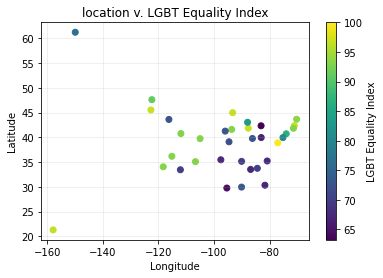

In [13]:
#latitude/longitude scatter with colored points based on lgbt equality index
plt.scatter(clean_city_data['Longitude'],clean_city_data['Latitude'],c=clean_city_data['LGBT Equality Index'])
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("LGBT Equality Index")
plt.title("location v. LGBT Equality Index")
plt.grid(alpha=.25)

#save as png
plt.savefig("figs/location_v_lgbt_equality")
plt.show()

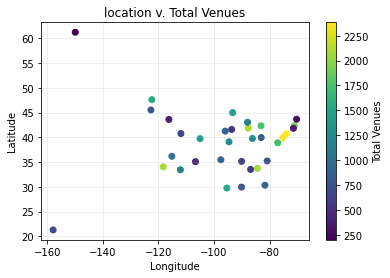

In [14]:
#latitude/longitude scatter with colored points based on total venues
plt.scatter(clean_city_data['Longitude'],clean_city_data['Latitude'],c=clean_city_data['Total Venues'])
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Total Venues")
plt.title("location v. Total Venues")
plt.grid(alpha=.25)

#save as png
plt.savefig("figs/location_v_venues")
plt.show()

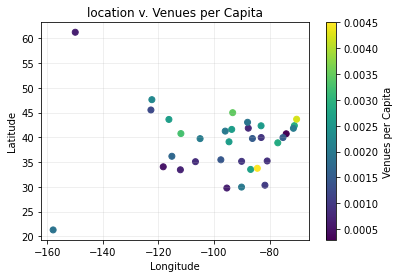

In [68]:
#latitude/longitude scatter with colored points based on venues per capita
plt.scatter(clean_city_data['Longitude'],clean_city_data['Latitude'],c=clean_city_data['Venues per Capita'])
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Venues per Capita")
plt.title("location v. Venues per Capita")
plt.grid(alpha=.25)

#save as png
plt.savefig("figs/location_v_venues_percapita")
plt.show()

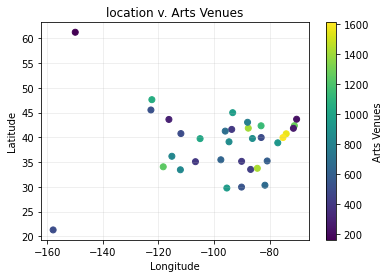

In [15]:
#latitude/longitude scatter with colored points based on arts venues
plt.scatter(clean_city_data['Longitude'],clean_city_data['Latitude'],c=clean_city_data['Arts Venues'])
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Arts Venues")
plt.title("location v. Arts Venues")
plt.grid(alpha=.25)

#save as png
plt.savefig("figs/location_v_arts")
plt.show()

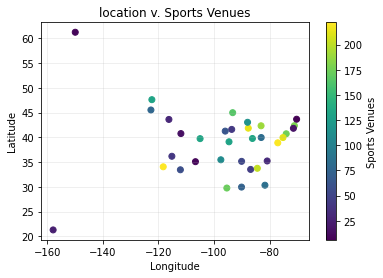

In [16]:
#latitude/longitude scatter with colored points based on sports venues
plt.scatter(clean_city_data['Longitude'],clean_city_data['Latitude'],c=clean_city_data['Sports Venues'])
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Sports Venues")
plt.title("location v. Sports Venues")
plt.grid(alpha=.25)

#save as png
plt.savefig("figs/location_v_sports")
plt.show()

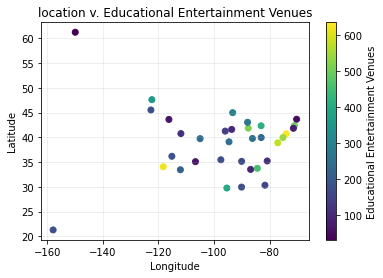

In [17]:
#latitude/longitude scatter with colored points based on ed venues
plt.scatter(clean_city_data['Longitude'],clean_city_data['Latitude'],c=clean_city_data['Educational Entertainment Venues'])
clb = plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
clb.set_label("Educational Entertainment Venues")
plt.title("location v. Educational Entertainment Venues")
plt.grid(alpha=.25)

#save as png
plt.savefig("figs/location_v_ed_venues")
plt.show()

y = 0.0x + 887.31
R squared: 0.3563235535774774


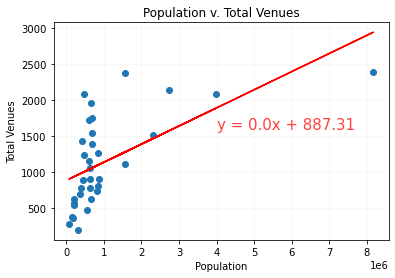

In [54]:
#population v total venues
plt.scatter(clean_city_data['Population'], clean_city_data['Total Venues'])
plt.xlabel('Population')
plt.ylabel('Total Venues')
plt.title('Population v. Total Venues')
plt.grid(alpha=.1)

#add linear regression line
(slope, intercept, rvalue, pvalue, stderr) = linregress(clean_city_data['Population'], clean_city_data['Total Venues'])
regress_values = clean_city_data['Population'] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

regress_values = clean_city_data['Population'] * slope + intercept
plt.plot(clean_city_data['Population'],regress_values,"r-")
print(line_eq)
plt.annotate(line_eq,(4e6,1600),fontsize=15,color="red", alpha=.75)

print(f"R squared: {rvalue**2}")

#save img
plt.savefig("figs/population_v_total_venues")

R squared: 0.0002439897642543394


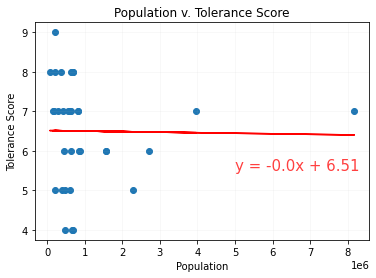

In [56]:
#population v tolerance score
plt.scatter(clean_city_data['Population'], clean_city_data['Tolerance Score'])
plt.xlabel('Population')
plt.ylabel('Tolerance Score')
plt.title('Population v. Tolerance Score')
plt.grid(alpha=.1)

#add linear regression line
(slope, intercept, rvalue, pvalue, stderr) = linregress(clean_city_data['Population'], clean_city_data['Tolerance Score'])
regress_values = clean_city_data['Population'] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(clean_city_data['Population'],regress_values,"r-")
plt.annotate(line_eq,(5e6,5.5),fontsize=15,color="red", alpha=.75)

print(f"R squared: {rvalue**2}")

#save img
plt.savefig("figs/population_v_tolerance_score")

R squared: 0.2869166676195268


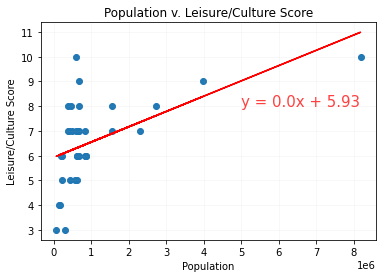

In [58]:
#population v culture score
plt.scatter(clean_city_data['Population'], clean_city_data['Leisure/Culture Score'])
plt.xlabel('Population')
plt.ylabel('Leisure/Culture Score')
plt.title('Population v. Leisure/Culture Score')
plt.grid(alpha=.1)

#add linear regression line
(slope, intercept, rvalue, pvalue, stderr) = linregress(clean_city_data['Population'], clean_city_data['Leisure/Culture Score'])
regress_values = clean_city_data['Population'] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(clean_city_data['Population'],regress_values,"r-")
plt.annotate(line_eq,(5e6,8),fontsize=15,color="red", alpha=.75)

print(f"R squared: {rvalue**2}")

#save img
plt.savefig("figs/population_v_LeisureCulture_Score")

R squared: 0.004793994052381387


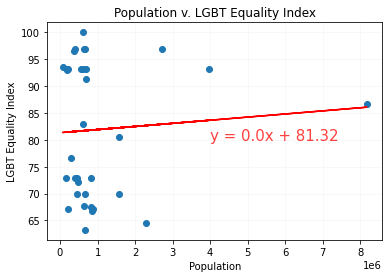

In [60]:
#population v lgbt index
plt.scatter(clean_city_data['Population'], clean_city_data['LGBT Equality Index'])
plt.xlabel('Population')
plt.ylabel('LGBT Equality Index')
plt.title('Population v. LGBT Equality Index')
plt.grid(alpha=.1)

#add linear regression line
(slope, intercept, rvalue, pvalue, stderr) = linregress(clean_city_data['Population'], clean_city_data['LGBT Equality Index'])
regress_values = clean_city_data['Population'] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(clean_city_data['Population'],regress_values,"r-")
plt.annotate(line_eq,(4e6,80),fontsize=15,color="red", alpha=.75)

print(f"R squared: {rvalue**2}")

#save img
plt.savefig("figs/population_v_LGBT_Equality_Index")

R squared: 0.01314142429963295


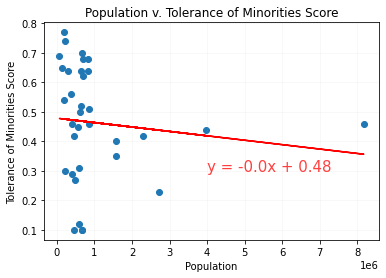

In [64]:
#population v tolerance of minorities
plt.scatter(clean_city_data['Population'], clean_city_data['Tolerance of Minorities Score'])
plt.xlabel('Population')
plt.ylabel('Tolerance of Minorities Score')
plt.title('Population v. Tolerance of Minorities Score')
plt.grid(alpha=.1)

#add linear regression line
(slope, intercept, rvalue, pvalue, stderr) = linregress(clean_city_data['Population'], clean_city_data['Tolerance of Minorities Score'])
regress_values = clean_city_data['Population'] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(clean_city_data['Population'],regress_values,"r-")
plt.annotate(line_eq,(4e6,.3),fontsize=15,color="red", alpha=.75)

print(f"R squared: {rvalue**2}")

#save img
plt.savefig("figs/population_v_tolerance_of_minorities")

R squared: 0.19297444182543463


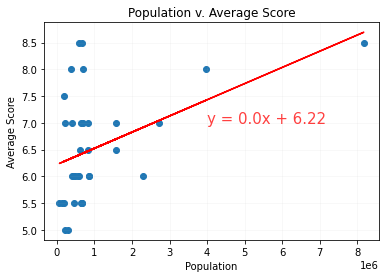

In [66]:
#population v average score
plt.scatter(clean_city_data['Population'], clean_city_data['Average Score'])
plt.xlabel('Population')
plt.ylabel('Average Score')
plt.title('Population v. Average Score')
plt.grid(alpha=.1)

#add linear regression line
(slope, intercept, rvalue, pvalue, stderr) = linregress(clean_city_data['Population'], clean_city_data['Average Score'])
regress_values = clean_city_data['Population'] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(clean_city_data['Population'],regress_values,"r-")
plt.annotate(line_eq,(4e6,7),fontsize=15,color="red", alpha=.75)

print(f"R squared: {rvalue**2}")

#save img
plt.savefig("figs/population_v_Average_Score")

In [76]:
#sort data by average score with venues per capita to sort cities with the same avg score and save top and bottom 5
sort_avgscore = clean_city_data
sort_avgscore = sort_avgscore.sort_values(by=['Average Score','Venues per Capita'], ascending = True, ignore_index=True)
sort_avgscore_bottom5 = sort_avgscore.head(5)

sort_avgscore = sort_avgscore.sort_values(by=['Average Score','Venues per Capita'], ascending = False, ignore_index=True)
sort_avgscore_top5 = sort_avgscore.head(5)


,State,City,Latitude,Longitude,Population,Leisure/Culture Score,Arts Venues,Educational Entertainment Venues,Sports Venues,Total Venues,LGBT Equality Index,Tolerance of Minorities Score,Tolerance Score,Average Score,Venues per Capita
0,MA,Boston,42.35843,-71.05977,667137.0,9,1279,498,179,1956,96.88,0.70,8,8.5,0.002932
1,DC,Washington,38.89511,-77.03637,601723.0,10,926,579,221,1726,100.00,0.31,7,8.5,0.002868
2,NY,New York City,40.71427,-74.00597,8175133.0,10,1573,636,175,2384,86.72,0.46,7,8.5,0.000292
3,WA,Seattle,47.60621,-122.33207,684451.0,8,1059,356,132,1547,91.25,0.68,8,8.0,0.002260
4,HI,Honolulu,21.30694,-157.85833,371657.0,8,495,182,25,702,96.55,0.56,8,8.0,0.001889


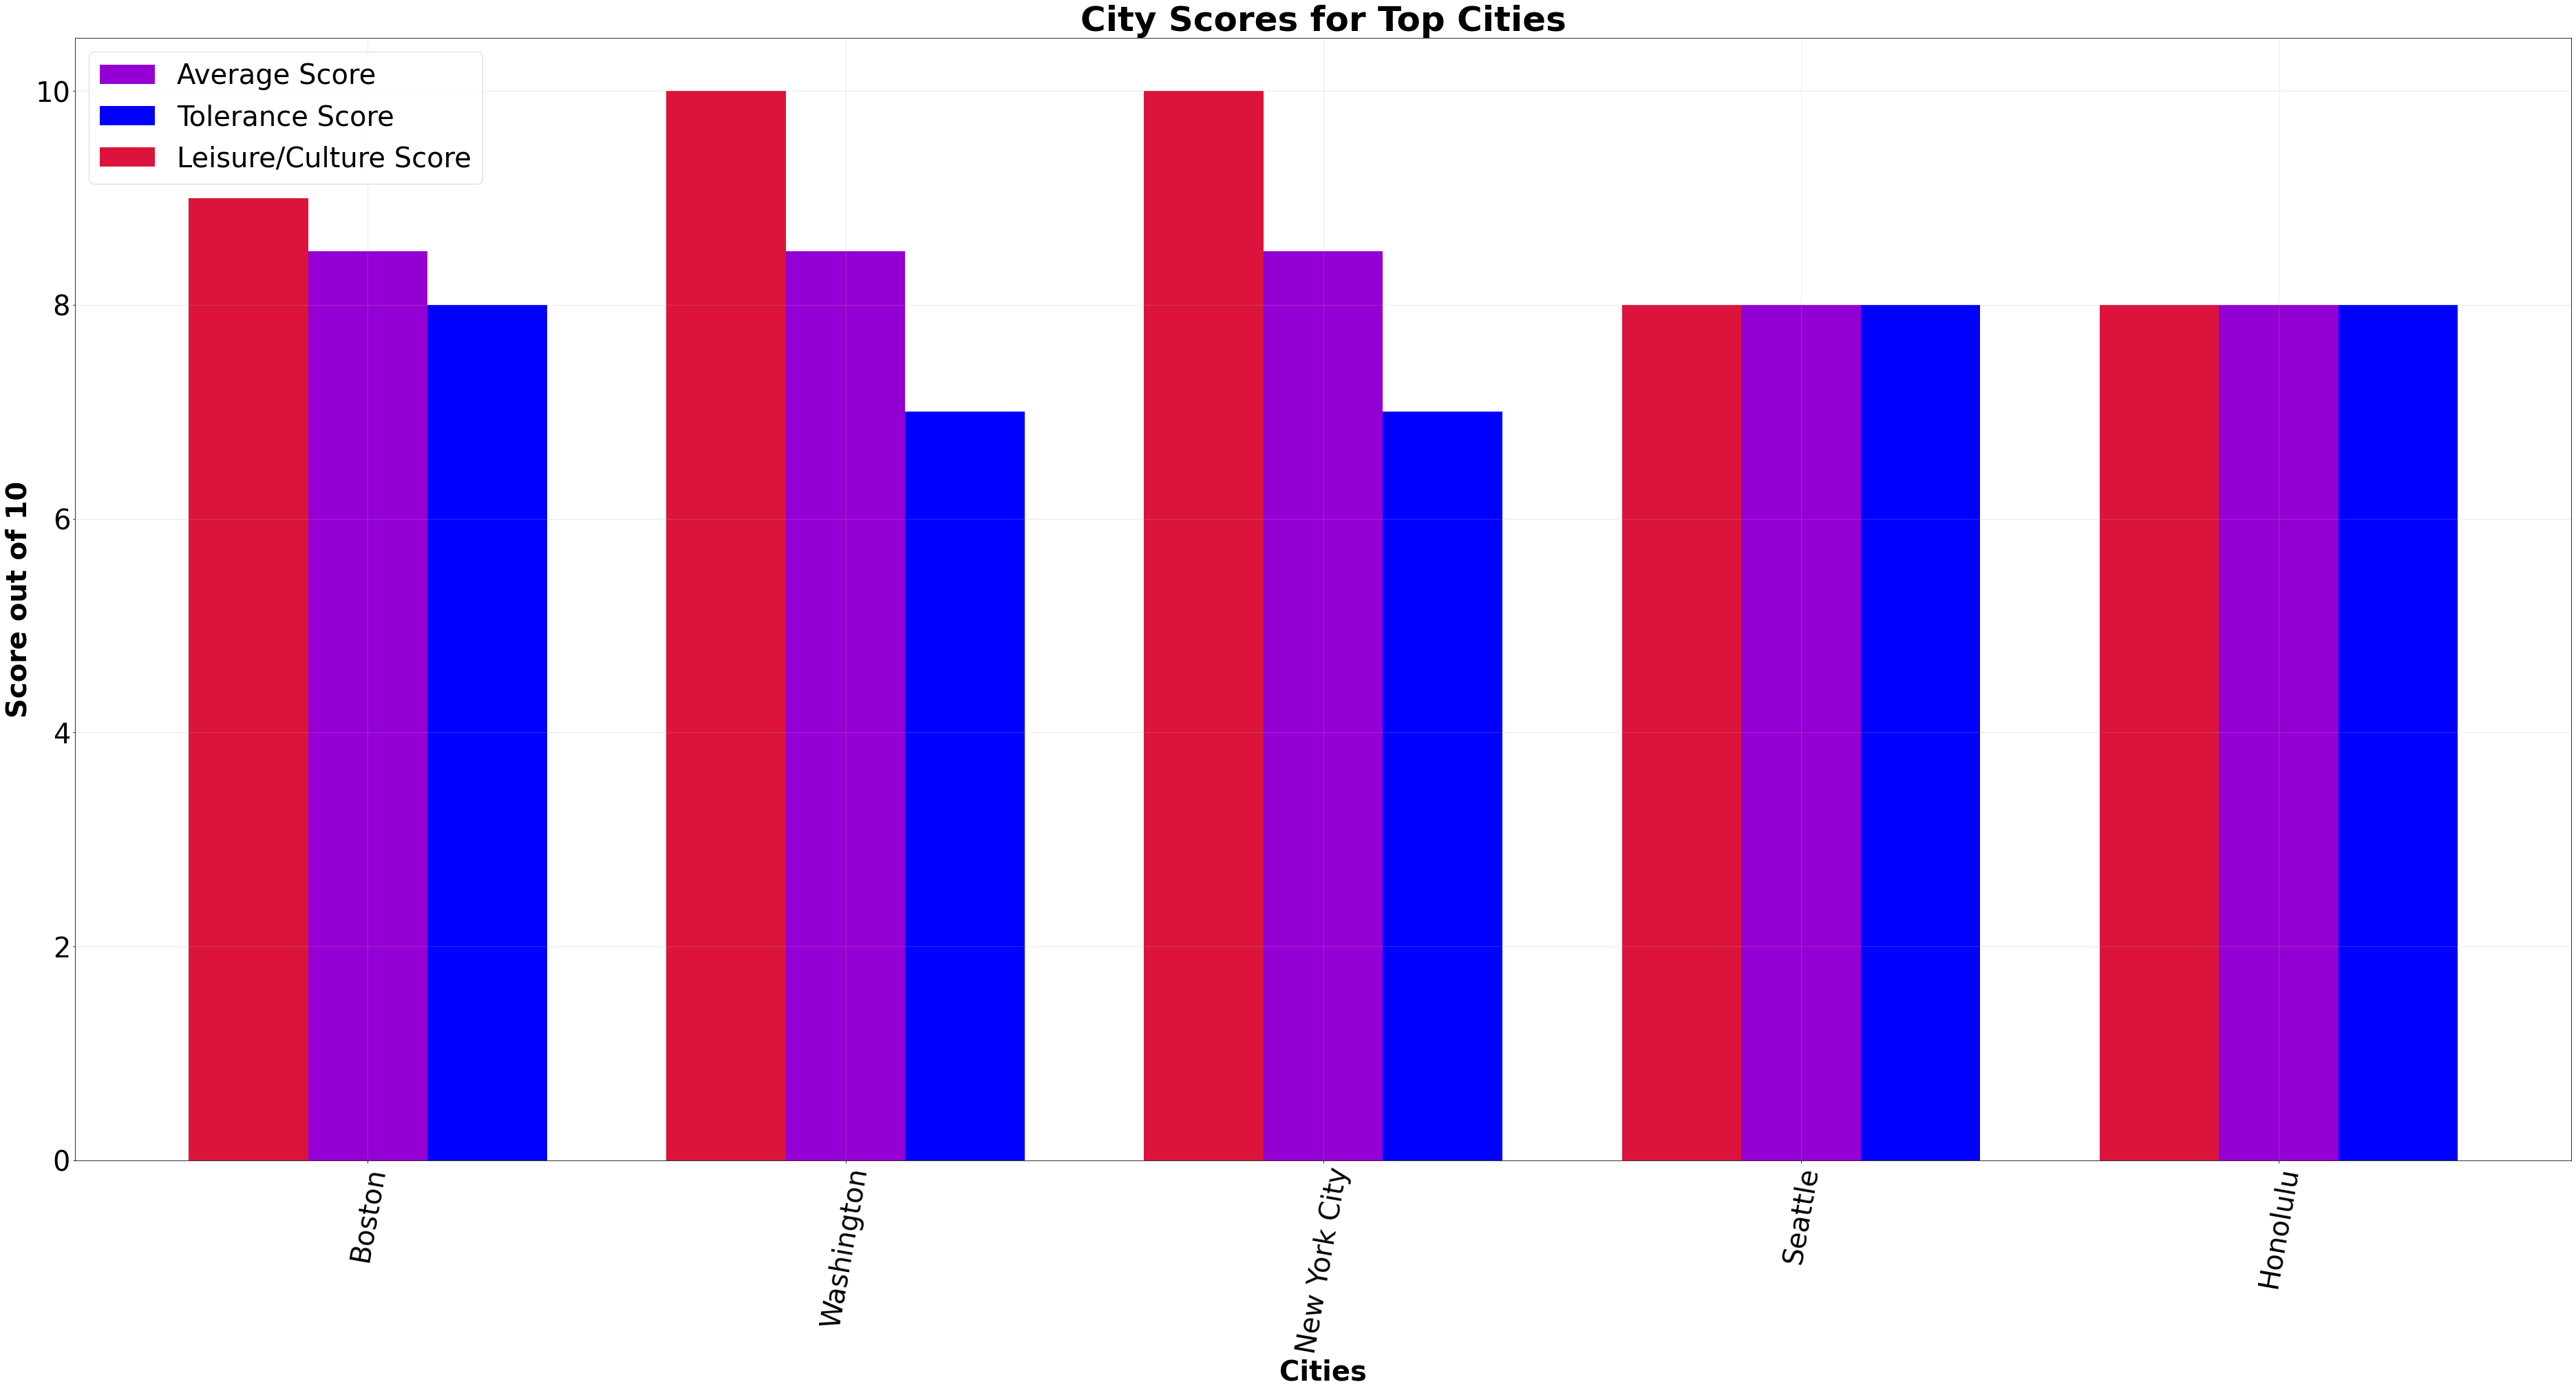

In [100]:
#bar chart comparing tolerance and leisure scores across top cities
plt.subplots(1, figsize=(65, 30))
x = np.arange(0, len(sort_avgscore_top5['City']))
plt.bar(x,sort_avgscore_top5['Average Score'], color='darkviolet', width=.25)
plt.bar(x + .25,sort_avgscore_top5['Tolerance Score'], color='blue', width=.25)
plt.bar(x - .25,sort_avgscore_top5['Leisure/Culture Score'], color='crimson', width=.25)

plt.yticks(fontsize=40)
plt.xticks(x,sort_avgscore_top5['City'],fontsize=40,rotation = 80)
plt.title("City Scores for Top Cities", fontsize=50, weight='bold')
plt.xlabel("Cities", fontsize=40, weight='bold')
plt.ylabel("Score out of 10", fontsize=40, weight='bold')
plt.grid(alpha=.3)
plt.legend(['Average Score','Tolerance Score','Leisure/Culture Score'],loc='upper left', fontsize=40)

#save as img
plt.savefig("figs/city_scores_top")

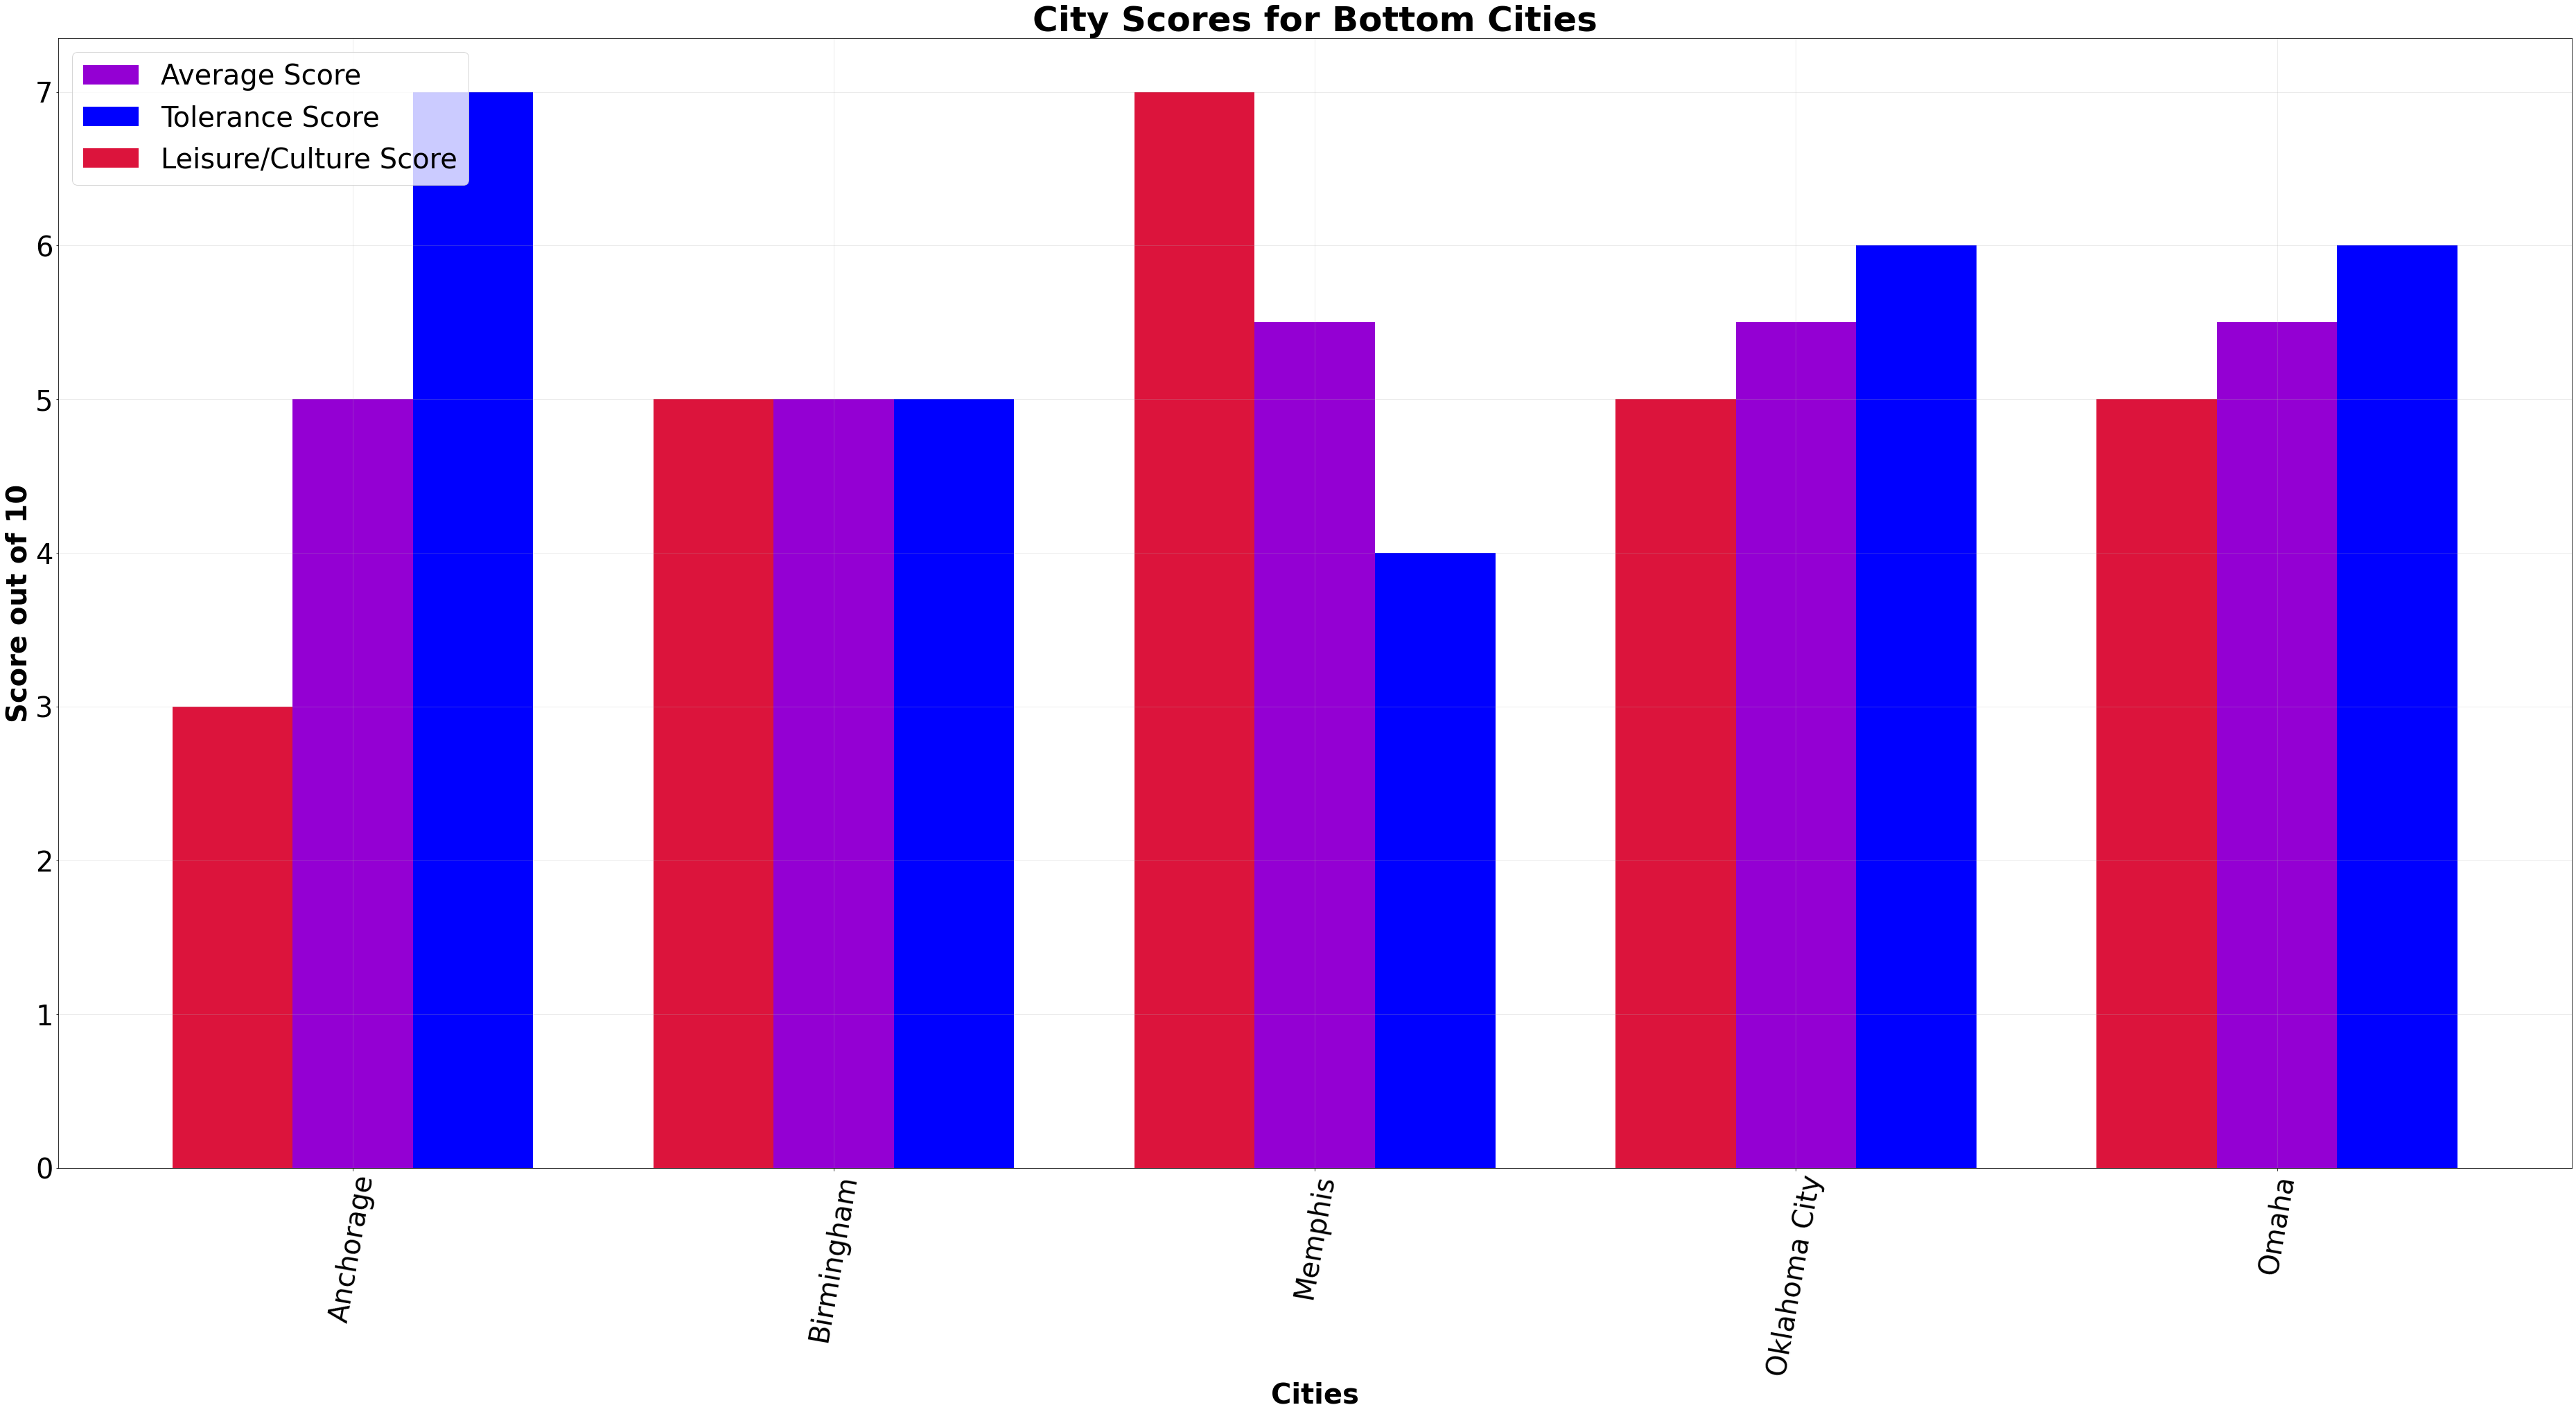

In [101]:
#bar chart comparing tolerance and leisure scores across bottom cities
plt.subplots(1, figsize=(65, 30))
x = np.arange(0, len(sort_avgscore_bottom5['City']))
plt.bar(x,sort_avgscore_bottom5['Average Score'], color='darkviolet', width=.25)
plt.bar(x + .25,sort_avgscore_bottom5['Tolerance Score'], color='blue', width=.25)
plt.bar(x - .25,sort_avgscore_bottom5['Leisure/Culture Score'], color='crimson', width=.25)

plt.yticks(fontsize=40)
plt.xticks(x,sort_avgscore_bottom5['City'],fontsize=40,rotation = 80)
plt.title("City Scores for Bottom Cities", fontsize=50, weight='bold')
plt.xlabel("Cities", fontsize=40, weight='bold')
plt.ylabel("Score out of 10", fontsize=40, weight='bold')
plt.grid(alpha=.3)
plt.legend(['Average Score','Tolerance Score','Leisure/Culture Score'],loc='upper left', fontsize=40)

#save as img
plt.savefig("figs/city_scores_bottom")

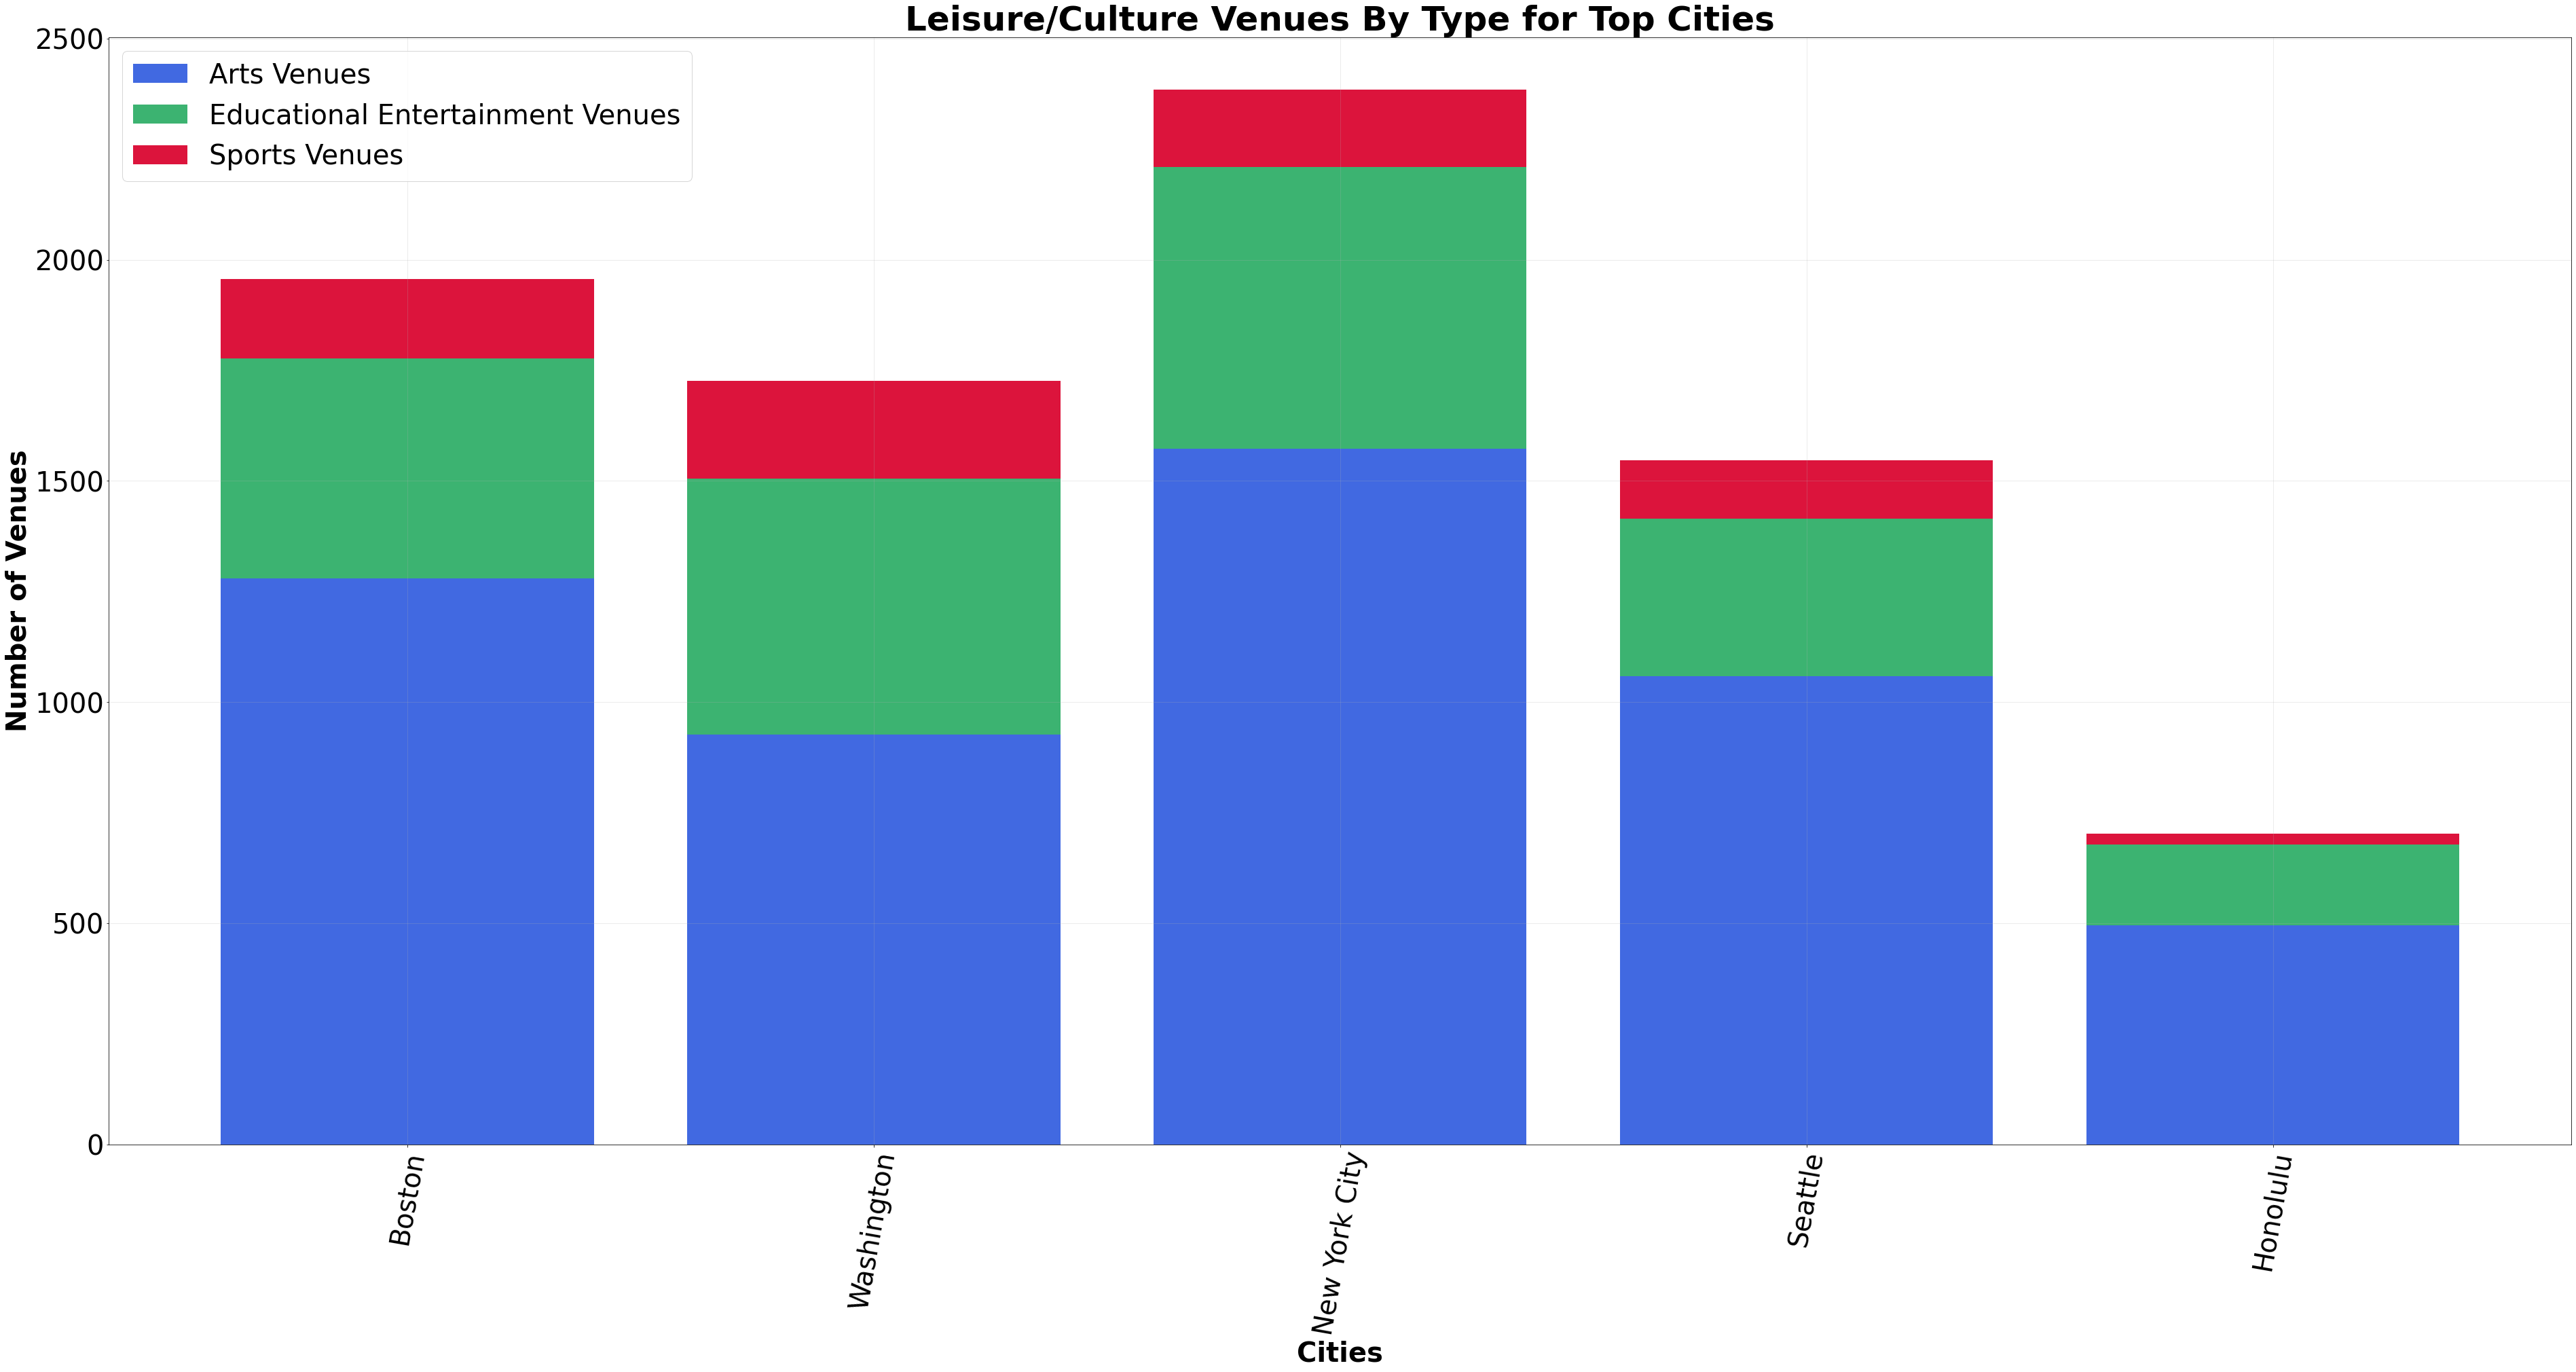

In [102]:
#make stacked bar chart to compare venue categories for top cities
plt.subplots(1, figsize=(65, 30))
plt.bar(sort_avgscore_top5['City'], sort_avgscore_top5['Arts Venues'], color='royalblue')
plt.bar(sort_avgscore_top5['City'], sort_avgscore_top5['Educational Entertainment Venues'], bottom=sort_avgscore_top5['Arts Venues'], color='mediumseagreen')
plt.bar(sort_avgscore_top5['City'], sort_avgscore_top5['Sports Venues'], bottom=sort_avgscore_top5['Arts Venues']+sort_avgscore_top5['Educational Entertainment Venues'], color='crimson')

plt.yticks(fontsize=40)
plt.xticks(fontsize=40,rotation = 80)
plt.title("Leisure/Culture Venues By Type for Top Cities", fontsize=50, weight='bold')
plt.xlabel("Cities", fontsize=40, weight='bold')
plt.ylabel("Number of Venues", fontsize=40, weight='bold')
plt.grid(alpha=.3)

plt.legend(['Arts Venues','Educational Entertainment Venues','Sports Venues'],loc='upper left', fontsize=40)

#save as img
plt.savefig("figs/Leisure_types_top_cities")

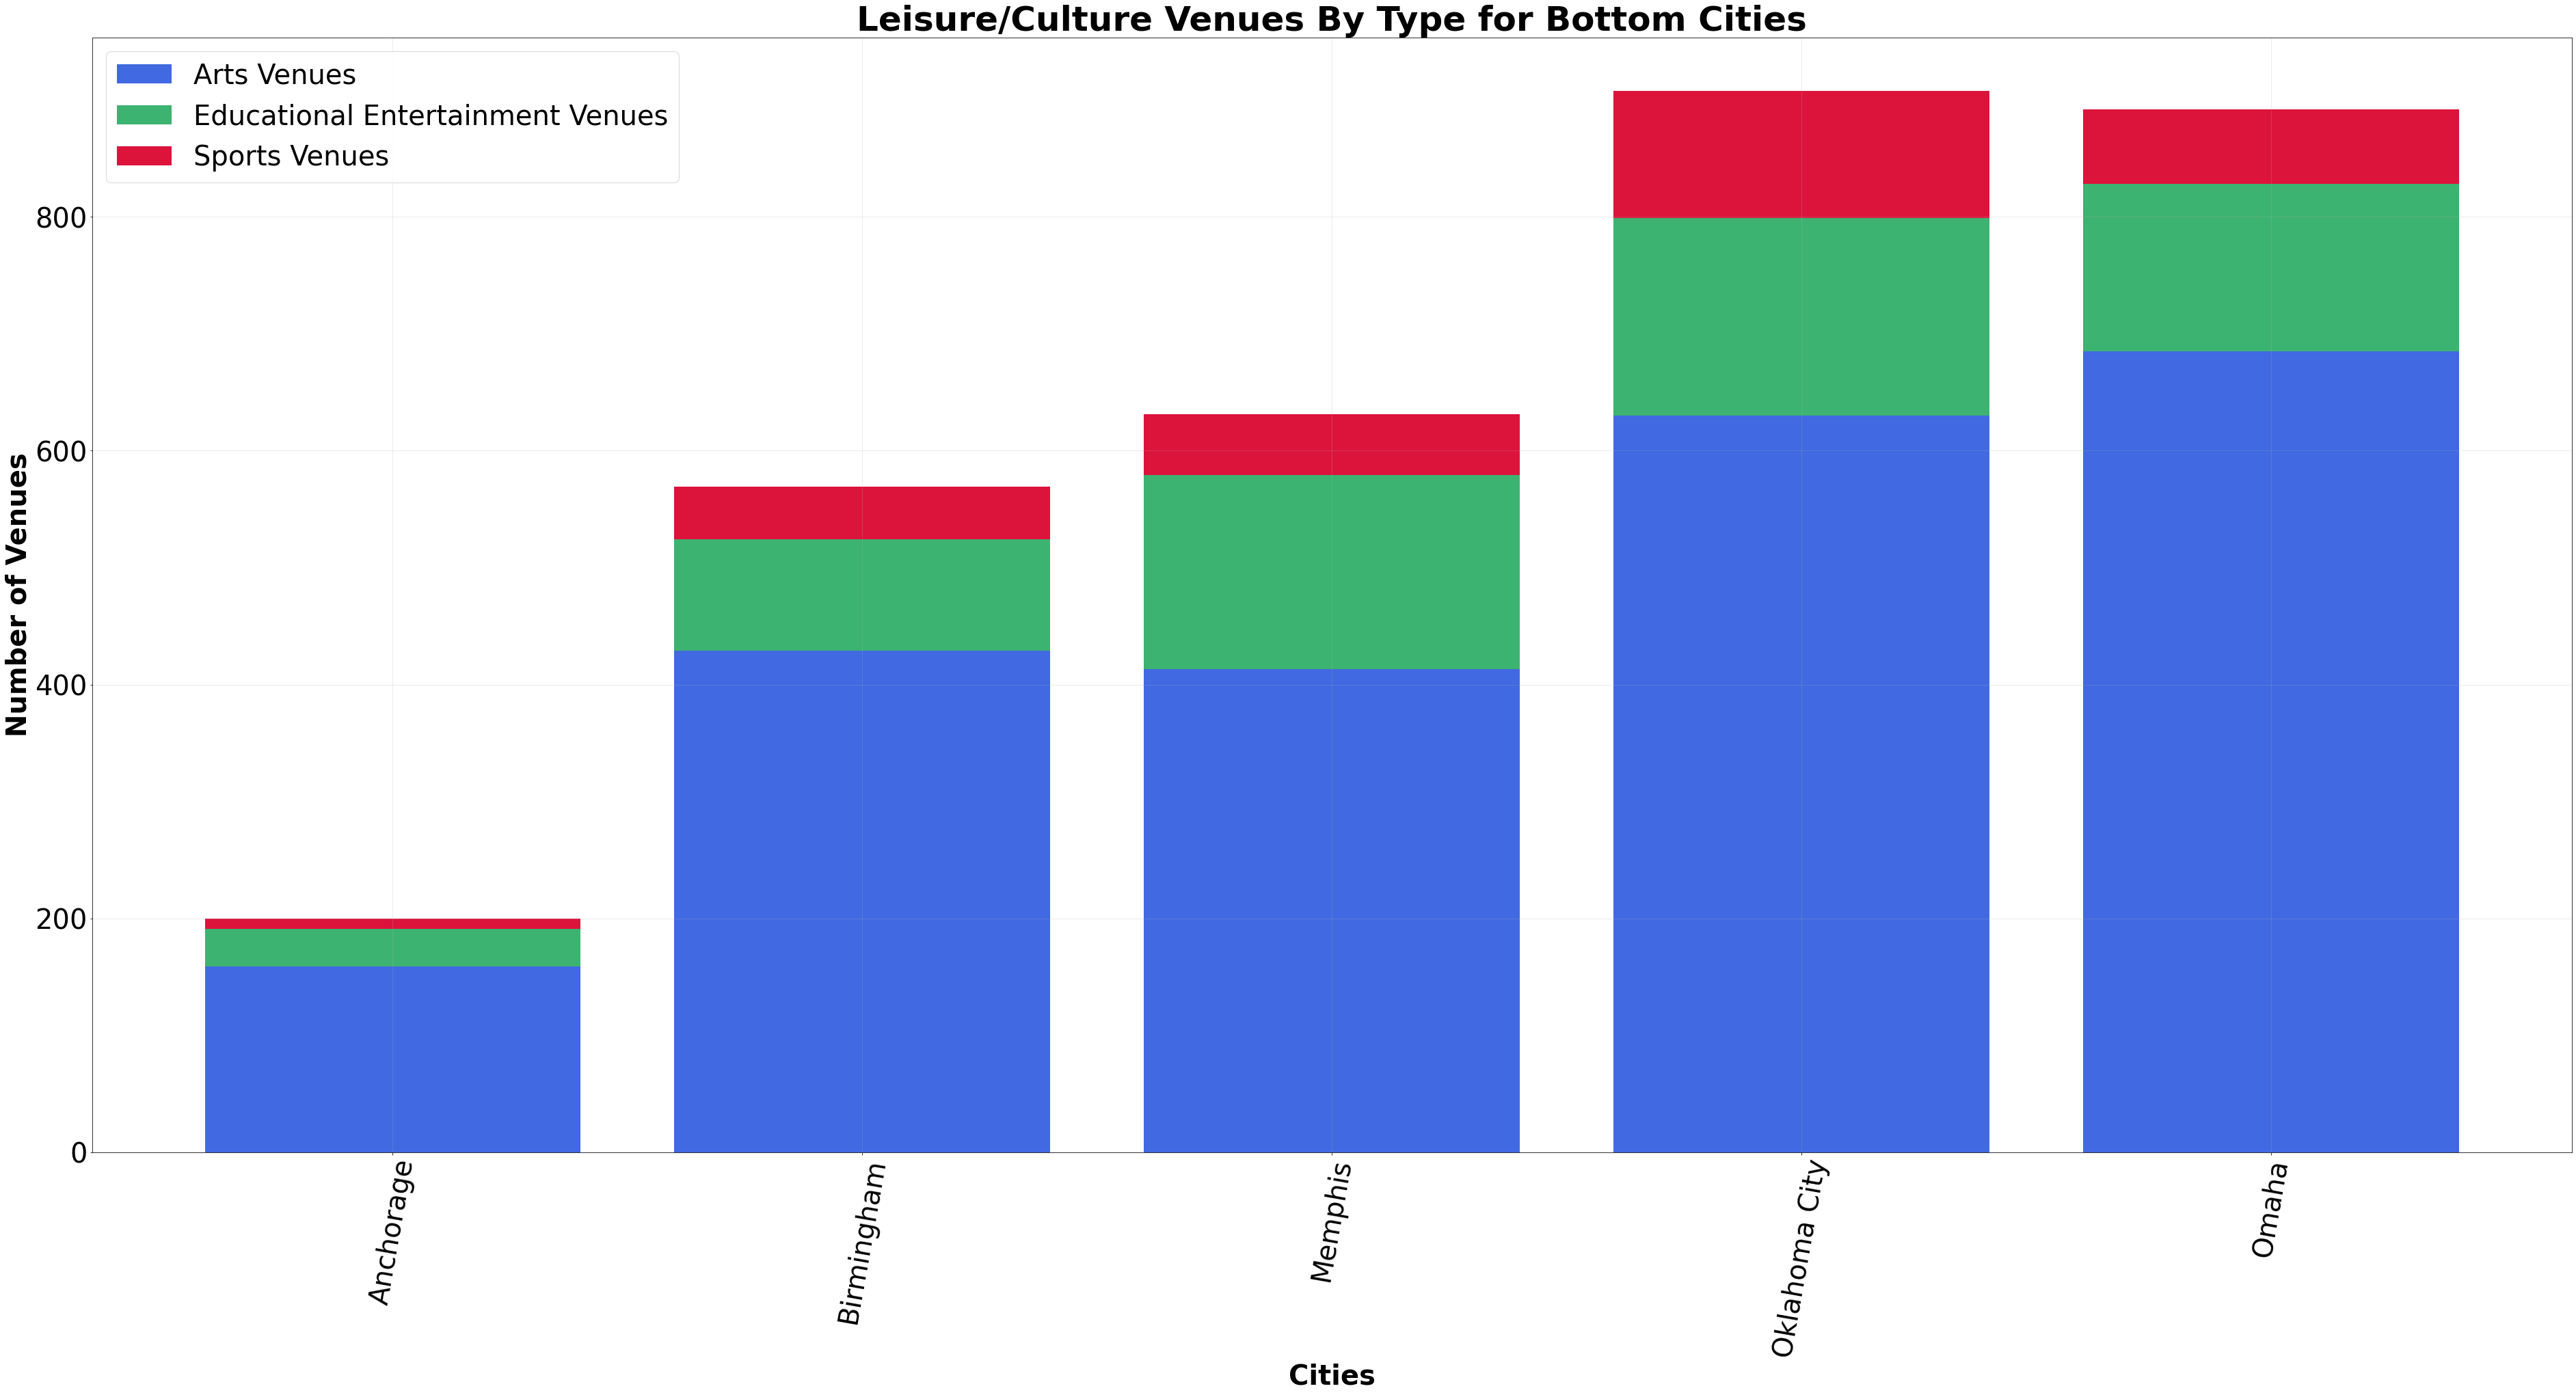

In [103]:
#make stacked bar chart to compare venue categories for bottom cities
plt.subplots(1, figsize=(65, 30))
plt.bar(sort_avgscore_bottom5['City'], sort_avgscore_bottom5['Arts Venues'], color='royalblue')
plt.bar(sort_avgscore_bottom5['City'], sort_avgscore_bottom5['Educational Entertainment Venues'], bottom=sort_avgscore_bottom5['Arts Venues'], color='mediumseagreen')
plt.bar(sort_avgscore_bottom5['City'], sort_avgscore_bottom5['Sports Venues'], bottom=sort_avgscore_bottom5['Arts Venues']+sort_avgscore_bottom5['Educational Entertainment Venues'], color='crimson')

plt.yticks(fontsize=40)
plt.xticks(fontsize=40,rotation = 80)
plt.title("Leisure/Culture Venues By Type for Bottom Cities", fontsize=50, weight='bold')
plt.xlabel("Cities", fontsize=40, weight='bold')
plt.ylabel("Number of Venues", fontsize=40, weight='bold')
plt.grid(alpha=.3)

plt.legend(['Arts Venues','Educational Entertainment Venues','Sports Venues'],loc='upper left', fontsize=40)

#save as img
plt.savefig("figs/Leisure_types_bottom_cities")